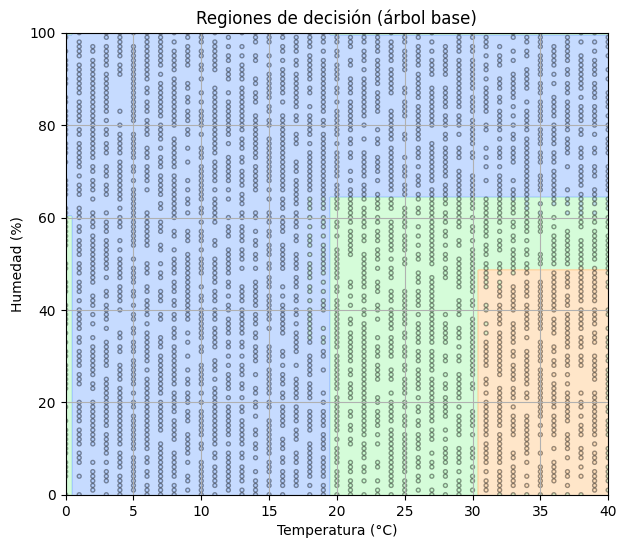

Accuracy test: 0.945

Reporte de clasificación:
              precision    recall  f1-score   support

        bajo       0.97      0.99      0.98       532
       medio       0.96      0.82      0.88       214
        alto       0.79      0.98      0.87        83

    accuracy                           0.94       829
   macro avg       0.90      0.93      0.91       829
weighted avg       0.95      0.94      0.94       829



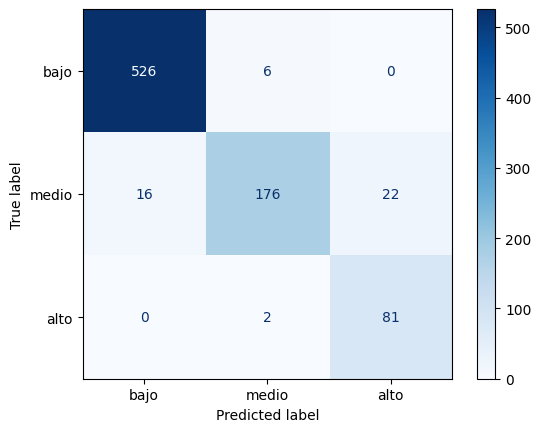

interactive(children=(FloatSlider(value=25.0, description='Temperatura (°C)', max=40.0, step=0.5), FloatSlider…

In [2]:
# ================================================================
# Árbol de Decisión para Recomendación de Riego (Colab-ready)
# Basado en las MISMAS REGLAS del ejemplo difuso
# ================================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from ipywidgets import interact, FloatSlider, IntSlider, Dropdown
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# -----------------------------
# 1) Definimos universos y membresías (para generar etiquetas sintéticas)
# -----------------------------
temp_u = np.arange(0, 41, 1)     # 0..40 °C
hum_u  = np.arange(0, 101, 1)    # 0..100 %

def trapmf(x, a, b, c, d):
    return np.maximum(0, np.minimum( (x-a)/(b-a+1e-9), np.minimum(1, (d-x)/(d-c+1e-9)) ))

def trimf(x, a, b, c):
    return np.maximum(0, np.minimum( (x-a)/(b-a+1e-9), (c-x)/(c-b+1e-9) ))

def mu_temp_baja(x):  return trapmf(x, 0, 0, 10, 20)
def mu_temp_media(x): return trimf(x, 15, 25, 35)
def mu_temp_alta(x):  return trapmf(x, 30, 35, 40, 40)

def mu_hum_seca(x):    return trapmf(x, 0, 0, 30, 50)
def mu_hum_media(x):   return trimf(x, 30, 50, 70)
def mu_hum_humeda(x):  return trapmf(x, 60, 80, 100, 100)

# Reglas (activación por producto/lógica mínima)
# R1: temp alta & hum seca -> riego alto
# R2: temp media & hum media -> riego medio
# R3: temp baja | hum húmeda -> riego bajo

def activaciones_rules(t, h):
    a1 = min(mu_temp_alta(t),  mu_hum_seca(h))      # -> alto
    a2 = min(mu_temp_media(t), mu_hum_media(h))     # -> medio
    a3 = max(mu_temp_baja(t),  mu_hum_humeda(h))    # -> bajo
    return a1, a2, a3

# Etiquetado por "winner-takes-all"
# 0=bajo, 1=medio, 2=alto
def etiquetar(t, h):
    a1, a2, a3 = activaciones_rules(t, h)
    activs = np.array([a3, a2, a1])  # orden: bajo, medio, alto
    if activs.max() == 0:
        # caso gris: sin activación -> elegimos "medio" por defecto (o lo que prefieras)
        return 1
    return activs.argmax()

# -----------------------------
# 2) Generamos dataset sintético a partir de las reglas difusas
# -----------------------------
T, H = np.meshgrid(temp_u, hum_u)
T_flat = T.ravel()
H_flat = H.ravel()
y = np.array([etiquetar(t, h) for t, h in zip(T_flat, H_flat)])

X = np.c_[T_flat, H_flat]   # features: [temperatura, humedad]

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# 3) Entrenamiento base (árbol de decisión)
# -----------------------------
def entrenar_arbol(criterion="gini", max_depth=4, min_samples_split=2, random_state=0):
    clf = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=random_state
    )
    clf.fit(X_train, y_train)
    return clf

clf = entrenar_arbol()

# -----------------------------
# 4) Evaluación rápida y visualización de la frontera
# -----------------------------
def plot_regiones_decision(model, title="Regiones de decisión (riego)"):
    # Malla
    x_min, x_max = 0, 40
    y_min, y_max = 0, 100
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Colores: 0=bajo, 1=medio, 2=alto
    cmap = ListedColormap(["#A0C4FF", "#B9FBC0", "#FFD6A5"])
    plt.figure(figsize=(7,6))
    plt.contourf(xx, yy, Z, alpha=0.6, cmap=cmap)
    plt.scatter(X_train[:3000,0], X_train[:3000,1], c=y_train[:3000], s=8, cmap=cmap, edgecolor="k", alpha=0.4)
    plt.title(title)
    plt.xlabel("Temperatura (°C)")
    plt.ylabel("Humedad (%)")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.grid(True)
    plt.show()

def evaluar_modelo(model):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy test: {acc:.3f}\n")
    print("Reporte de clasificación:")
    print(classification_report(y_test, y_pred, target_names=["bajo","medio","alto"]))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["bajo","medio","alto"])
    disp.plot(values_format='d', cmap="Blues")
    plt.show()

plot_regiones_decision(clf, "Regiones de decisión (árbol base)")
evaluar_modelo(clf)

# -----------------------------
# 5) Interactivo: predicción y tuning de hiperparámetros
# -----------------------------
label_to_str = {0:"bajo", 1:"medio", 2:"alto"}

def demo_interact(temp, hum, criterion, max_depth, min_samples_split):
    model = entrenar_arbol(
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=0
    )

    # Predicción y probas
    proba = model.predict_proba([[temp, hum]])[0]
    pred  = proba.argmax()
    nivel = label_to_str[pred]

    print(f"🌡️ Temperatura: {temp:.1f} °C  |  💧 Humedad: {hum:.1f} %")
    print(f"🔮 Árbol → Riego recomendado: **{nivel.upper()}**")
    print(f"   Probabilidades [bajo, medio, alto]: {proba.round(3)}")

    # Mapa de decisión (opcional: rápido)
    plot_regiones_decision(model, f"Regiones de decisión (criterion={criterion}, depth={max_depth})")

    # Mostrar el árbol
    plt.figure(figsize=(12,6))
    plot_tree(model, feature_names=["temperatura", "humedad"],
              class_names=["bajo","medio","alto"], filled=True, rounded=True, fontsize=8)
    plt.title("Árbol de decisión")
    plt.show()

interact(
    demo_interact,
    temp=FloatSlider(min=0, max=40, step=0.5, value=25, description="Temperatura (°C)"),
    hum=FloatSlider(min=0, max=100, step=1, value=50, description="Humedad (%)"),
    criterion=Dropdown(options=[("Gini","gini"), ("Entropía","entropy"), ("Log Loss","log_loss")],
                       value="gini", description="Criterio"),
    max_depth=IntSlider(min=1, max=12, step=1, value=4, description="Profundidad"),
    min_samples_split=IntSlider(min=2, max=20, step=1, value=2, description="Min. split")
);

# -----------------------------
# 6) (Opcional) Cargar tu propio CSV
#    Debe tener columnas: temperatura, humedad, objetivo (bajo|medio|alto)
# -----------------------------
# from google.colab import files
# import pandas as pd
# print("Sube tu CSV con columnas: temperatura, humedad, objetivo")
# up = files.upload()
# nombre = list(up.keys())[0]
# df = pd.read_csv(nombre)
# # Convertir etiquetas a 0/1/2:
# mapa = {"bajo":0, "medio":1, "alto":2}
# df = df.dropna(subset=["temperatura","humedad","objetivo"])
# y_real = df["objetivo"].map(mapa).values
# X_real = df[["temperatura","humedad"]].values
# X_tr, X_te, y_tr, y_te = train_test_split(X_real, y_real, test_size=0.2, random_state=42, stratify=y_real)
# clf_real = DecisionTreeClassifier(criterion="gini", max_depth=4, random_state=0).fit(X_tr, y_tr)
# print("Accuracy con datos reales:", accuracy_score(y_te, clf_real.predict(X_te)).round(3))
# plot_regiones_decision(clf_real, "Regiones (datos reales)")
# evaluar_modelo(clf_real)


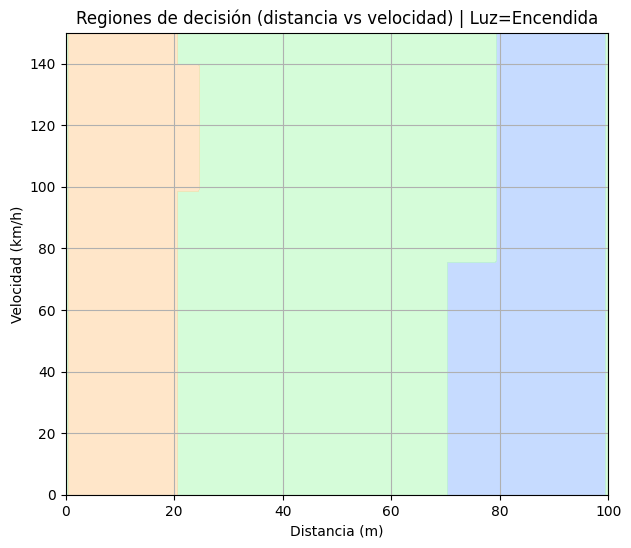

Accuracy: 0.999
              precision    recall  f1-score   support

        nulo       1.00      1.00      1.00      1482
    moderado       1.00      1.00      1.00      3345
      fuerte       1.00      1.00      1.00      1274

    accuracy                           1.00      6101
   macro avg       1.00      1.00      1.00      6101
weighted avg       1.00      1.00      1.00      6101



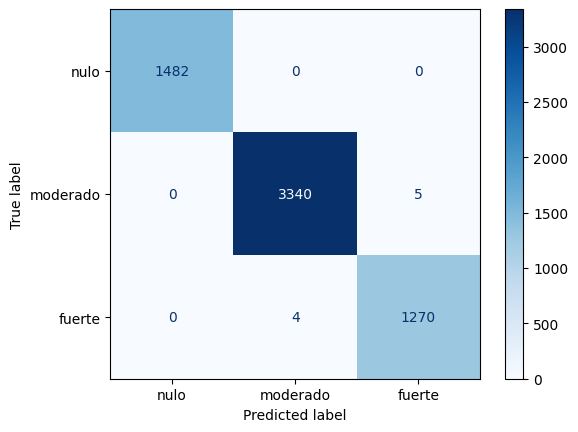

interactive(children=(FloatSlider(value=30.0, description='Distancia (m)', step=1.0), Dropdown(description='Lu…

In [3]:
# ================================================================
# Árbol de Decisión para Frenado (clasificación: nulo/medio/fuerte)
# Aprende a partir de las mismas reglas del sistema difuso
# ================================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from ipywidgets import interact, FloatSlider, IntSlider, Dropdown
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# ---------- 1) Membresías (equivalentes a tu código difuso) ----------
def trapmf(x, a, b, c, d):
    return np.maximum(0, np.minimum((x-a)/(b-a+1e-9), np.minimum(1, (d-x)/(d-c+1e-9))))

def trimf(x, a, b, c):
    return np.maximum(0, np.minimum((x-a)/(b-a+1e-9), (c-x)/(c-b+1e-9)))

def gaussmf(x, c, sigma):
    return np.exp(-0.5*((x-c)/sigma)**2)

# Universos
dist_u = np.arange(0, 101, 1)      # metros
vel_u  = np.arange(0, 151, 1)      # km/h
luz_u  = np.array([0,1])           # 0=apagada, 1=encendida

# Distancia
def mu_dist_corta(x): return trapmf(x, 0, 0, 10, 30)
def mu_dist_media(x): return trapmf(x, 20, 40, 60, 80)
def mu_dist_larga(x): return trapmf(x, 70, 90, 100, 100)

# Luz de freno
def mu_luz_apagada(x):   return trimf(x, 0, 0, 1)   # 0..1
def mu_luz_encendida(x): return trimf(x, 0, 1, 1)

# Velocidad
def mu_vel_baja(x):  return gaussmf(x, 30, 10)
def mu_vel_media(x): return gaussmf(x, 75, 15)
def mu_vel_alta(x):  return gaussmf(x, 120, 10)

# ---------- 2) Reglas (mismas que tu sistema difuso) ----------
# r1: dist corta & luz encendida & vel alta -> fuerte
# r2: dist corta & vel alta -> fuerte
# r3: dist media & luz encendida -> moderado
# r4: dist larga & vel baja -> nulo
# r5: luz apagada & vel baja -> nulo
# r6: dist media & vel alta -> moderado
# r7: dist corta & luz apagada -> moderado

# winner-takes-all: 0=nulo, 1=moderado, 2=fuerte
def etiqueta_frenado(dist, luz, vel):
    a1 = min(mu_dist_corta(dist), mu_luz_encendida(luz), mu_vel_alta(vel))  # fuerte
    a2 = min(mu_dist_corta(dist), mu_vel_alta(vel))                         # fuerte
    a3 = min(mu_dist_media(dist), mu_luz_encendida(luz))                    # moderado
    a4 = min(mu_dist_larga(dist), mu_vel_baja(vel))                         # nulo
    a5 = min(mu_luz_apagada(luz), mu_vel_baja(vel))                         # nulo
    a6 = min(mu_dist_media(dist), mu_vel_alta(vel))                         # moderado
    a7 = min(mu_dist_corta(dist), mu_luz_apagada(luz))                      # moderado

    act_nulo     = max(a4, a5)
    act_moderado = max(a3, a6, a7)
    act_fuerte   = max(a1, a2)

    acts = np.array([act_nulo, act_moderado, act_fuerte])
    if acts.max() == 0:
        # caso gris -> moderado por defecto
        return 1
    return int(acts.argmax())

# ---------- 3) Dataset sintético a partir de las reglas ----------
D, V, L = np.meshgrid(dist_u, vel_u, np.array([0,1]))  # 0: apagada, 1: encendida
D_f = D.ravel(); V_f = V.ravel(); L_f = L.ravel()

y = np.array([etiqueta_frenado(d, l, v) for d, l, v in zip(D_f, L_f, V_f)])  # 0/1/2
X = np.c_[D_f, L_f, V_f]  # [distancia, luz, velocidad]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------- 4) Entrenamiento ----------
def entrenar_arbol(criterion="gini", max_depth=5, min_samples_split=2, random_state=0):
    clf = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=random_state
    )
    clf.fit(X_train, y_train)
    return clf

clf = entrenar_arbol()

# ---------- 5) Ayudas visuales ----------
cmap3 = ListedColormap(["#A0C4FF", "#B9FBC0", "#FFD6A5"])  # nulo, moderado, fuerte
labels = {0:"nulo", 1:"moderado", 2:"fuerte"}

def plot_regiones_dist_vel(model, luz=1, title="Regiones de decisión (distancia vs velocidad)"):
    dmin,dmax = 0,100; vmin,vmax = 0,150
    dd, vv = np.meshgrid(np.linspace(dmin,dmax,300), np.linspace(vmin,vmax,300))
    ll = np.full_like(dd, luz)
    Z = model.predict(np.c_[dd.ravel(), ll.ravel(), vv.ravel()]).reshape(dd.shape)

    plt.figure(figsize=(7,6))
    plt.contourf(dd, vv, Z, levels=[-0.5,0.5,1.5,2.5], alpha=0.6, cmap=cmap3)
    plt.xlabel("Distancia (m)")
    plt.ylabel("Velocidad (km/h)")
    plt.title(f"{title} | Luz={'Encendida' if luz==1 else 'Apagada'}")
    plt.grid(True)
    plt.show()

def evaluar(clf):
    y_pred = clf.predict(X_test)
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
    print(classification_report(y_test, y_pred, target_names=["nulo","moderado","fuerte"]))
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=["nulo","moderado","fuerte"]).plot(cmap="Blues", values_format='d')
    plt.show()

plot_regiones_dist_vel(clf, luz=1)
evaluar(clf)

# ---------- 6) Interactivo: probar valores y tunear hiperparámetros ----------
def demo_interact(dist, luz, vel, criterion, max_depth, min_samples_split):
    model = entrenar_arbol(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)
    proba = model.predict_proba([[dist, luz, vel]])[0]
    pred = int(np.argmax(proba))
    print(f"🚗 Distancia={dist:.1f} m | Luz={'encendida' if luz==1 else 'apagada'} | Velocidad={vel:.1f} km/h")
    print(f"🔮 Árbol → Frenado recomendado: **{labels[pred].upper()}**")
    print(f"   Probabilidades [nulo, moderado, fuerte]: {np.round(proba,3)}")

    plot_regiones_dist_vel(model, luz=int(luz),
                           title=f"criterion={criterion}, depth={max_depth}, min_split={min_samples_split}")

    plt.figure(figsize=(14,6))
    plot_tree(model,
              feature_names=["distancia","luz_freno","velocidad"],
              class_names=["nulo","moderado","fuerte"],
              filled=True, rounded=True, fontsize=8)
    plt.title("Árbol de decisión (frenado)")
    plt.show()

interact(
    demo_interact,
    dist=FloatSlider(min=0, max=100, step=1, value=30, description="Distancia (m)"),
    luz=Dropdown(options=[("Apagada",0), ("Encendida",1)], value=1, description="Luz freno"),
    vel=FloatSlider(min=0, max=150, step=1, value=60, description="Velocidad (km/h)"),
    criterion=Dropdown(options=[("Gini","gini"), ("Entropía","entropy"), ("Log Loss","log_loss")],
                       value="gini", description="Criterio"),
    max_depth=IntSlider(min=1, max=12, step=1, value=5, description="Profundidad"),
    min_samples_split=IntSlider(min=2, max=30, step=1, value=2, description="Min. split")
);
